# How does socioeconomic status affect crime rates in Seattle?
## Chantria Im, Ellie Velez, and Nawaf Osman

### Summary
**1. Is there a correlation between income and the prevalence of crimes in Seattle?**

Yes, there is a correlation. As median income decreases, the prevalence of crimes tends to increase.

**2. Is there a correlation between poverty rates and crime rates in Seattle?**

Yes, there is a correlation. Higher poverty rates are associated with higher crime rates in Seattle.

**3. Is there a correlation between policing times and the socioeconomic status of a census tract in Seattle?**

Yes, there is a correlation, however, it isn’t very strong. As median income decreases and poverty rate increases, average police response times tend to decrease slightly.

### Motivation
Prevalence of crime threatens the safety of communities and affects the overall wellbeing of its residents. Understanding the relationship between crime prevalence and socioeconomic factors, such as poverty and income, can enable us to gain important insights and identify the underlying causes of higher incidences of crime in specific neighborhoods. By utilizing data, we can recognize trends, patterns, and correlations, allowing policymakers to make informed decisions to better aid and improve the public safety of neighborhoods as well as the quality of life of its population.

### Data Setting
Crime Dataset: [SPD Crime Data: 2008-Present | City of Seattle Open Data portal](https://data.seattle.gov/Public-Safety/SPD-Crime-Data-2008-Present/tazs-3rd5/about_data)

This dataset represents Seattle crime offense data from 2008 to present, as reported by the Seattle Police Department. The main columns we will be focusing on in this dataset include an "Offense Parent Group" column listing the parent group of the misdemeanors or felonies, an "Offense Start DateTime" listing the date and time the offense reportedly started, a "Report DateTime" column listing the date and time of the report, and geospatial data ("Longitude" and "Latitude") columns listing where exactly the offense occurred.

The context of this dataset might complicate or deepen our analysis by:
1. Providing insights about the census tracts where crime rates are highest, which we can later attempt to link to socioeconomic factors and disparities.
2. Providing insights about the types of offenses commonly committed, helping us understand the crime landscape of Seattle census tracts.
3. Providing data on the time between the occurrence and reporting of crimes, which can help us examine reporting patterns and thereby allow us to indicate possible differences in police response time across different census tracts.

Income Dataset: [Census 2018 ACS Median Income Data](https://data.census.gov/table?q=S1903:%20Median%20Income%20in%20the%20Past%2012%20Months%20(in%202022%20Inflation-Adjusted%20Dollars)&g=050XX00US53033$1400000&y=2018)

Poverty Dataset: [Seattle RSJI Poverty Data](https://www.seattle.gov/rsji/racial-equity-research/poverty#thegovernmentsofficialtools)

Boundries Dataset: [Washington Census Tract Cartographic Boundry Data](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html)

API: [Census Geocoder](https://www.census.gov/programs-surveys/geography/technical-documentation/complete-technical-documentation/census-geocoder.html)

### Method
**1. Data Preparation:** Import, clean, filter, and augment/structure crime, income, poverty, and boundries datasets.

In [1]:
# Install packages
import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install folium mapclassify

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# Import libraries
import pandas as pd
import requests
import re
import time
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

In [3]:
# Load datasets
crime_df = pd.read_csv('./data/SPD_Crime_Data__2008-Present_20240226.csv')
poverty_df = pd.read_csv('./data/Poverty_and_Near_Poverty_Map_Full_Data_data.csv', 
                         converters={'Census Tract': str.strip})
income_df = pd.read_csv('./data/ACSST5Y2018.S1903-Data.csv')
boundries_df = gpd.read_file('./data/cb_2018_53_tract_500k/cb_2018_53_tract_500k.shp')

In [4]:
def crime_clean(crime_df):
    """
    Takes a dataframe representing crime data and returns the cleaned dataframe.
    """
    
    # Remove rows with missing Longitude and Latitude values
    # The following offense types purposefully lack geodata:
    # ['KIDNAPPING/ABDUCTION', 'SEX OFFENSES', 'HUMAN TRAFFICKING', 'FAMILY OFFENSES, NONVIOLENT', 'ANIMAL CRUELTY',
    # 'HOMICIDE OFFENSES', 'PEEPING TOM', 'DRUNKENNESS', SEX OFFENSES, CONSENSUAL']
    crime_df = crime_df[(crime_df['Longitude'] != 0) & (crime_df['Latitude'] != 0)].copy()

    # Filter for only 2018 entries
    crime_df['Report DateTime'] = pd.to_datetime(crime_df['Report DateTime'], format='%m/%d/%Y %I:%M:%S %p')
    crime_df = crime_df[crime_df['Report DateTime'].dt.year == 2018]

    # Add Census Tract column
    crime_df['Census Tract'] = pd.Series(dtype='string')
    
    # Drop un-needed columns
    crime_df = crime_df.filter(['Census Tract', 'Offense Start DateTime', 'Report DateTime', 'Offense Parent Group', 
                                'Longitude', 'Latitude'])
    return crime_df
   
crime_df = crime_clean(crime_df)

In [5]:
def crime_tracts(crime_df):
    """
    Takes a dataframe representing cleaned crime data.
    Returns the dataframe with populated census tract numbers for each offense.
    """
    
    # Fill Census Tract column with corresponding census tract numbers
    i = 0
    while i < len(crime_df):
        # Make request to Census Geocoder API to get row census tract data based on row longtitude and latitude values
        payload = {'benchmark': 'Public_AR_Current', 'vintage': 'ACS2018_Current', 'x': crime_df['Longitude'].iloc[i], 
                   'y': crime_df['Latitude'].iloc[i], 'format': 'json', 'layers': 'Census Tracts'}
        try:
            r = requests.get(f'https://geocoding.geo.census.gov/geocoder/geographies/coordinates', params=payload)
        except requests.Timeout:
            time.sleep(300)
            continue
        # Extract the census tract number from the response and store it in the Census Tract column
        crime_df['Census Tract'].iloc[i] = re.findall('\d+\.\d+|\d+', 
                                                      r.json()['result']['geographies']['Census Tracts'][0]['NAME'])[0]
        i += 1
    
    return crime_df.drop(['Longitude', 'Latitude'], axis=1)

In [6]:
%%capture
%%script echo skipping # Skip this code cell to avoid recomputing (5+ hours)

crime_df = crime_tracts(crime_df)

# Backup dataframe to disk 
crime_df.to_csv('./data/crime.csv')

In [7]:
# Cache the dataframe
# %store crime_df

# Reload the dataframe from cache rather than recomputing (5+ hours)
# %store -r crime_df

# Reload the dataframe from disk backup rather than recomputing (5+ hours)
crime_df = pd.read_csv('./data/crime.csv', converters={'Census Tract': str.strip}, parse_dates=['Report DateTime'])

In [8]:
def income_clean(income_df):
    """
    Takes a dataframe representing income data and returns the cleaned dataframe.
    """
    
    # Remove rows with missing median income values
    # The following census tracts lack median income values:
    # ['53.02', '9901']
    income_df = income_df[pd.to_numeric(income_df['S1903_C03_001E'], errors='coerce').notna()]

    # Extract and set census tract numbers
    for i in range(len(income_df)):
        income_df.iat[i, income_df.columns.get_loc('NAME')] = re.findall('\d+\.\d+|\d+', income_df['NAME'].iloc[i])[0]

    # Edit column names
    income_df = income_df.rename(columns={'NAME': 'Census Tract', 'S1903_C03_001E': 'Median Income'})

    # Set median income column to numeric type
    income_df['Median Income'] = pd.to_numeric(income_df['Median Income'])
    
    # Drop un-needed columns
    income_df = income_df.filter(['Census Tract', 'Median Income'])
    return income_df

income_df = income_clean(income_df)

In [9]:
def poverty_clean(poverty_df):
    """
    Takes a dataframe representing poverty data and returns the cleaned dataframe.
    """
    
    # Drop empty columns
    poverty_df = poverty_df.drop(['% of Population Under 100% Poverty Line', '% of Population Under 200% Poverty Line', 
                                  'Share Below Selected % of Poverty Level'], axis=1)

    # Group data by census tract and calculate total poverty population for levels
    poverty_by_tract = poverty_df[poverty_df['Name'] != 'Total'].groupby('Census Tract').agg(
        {'Population Under 100% Poverty Level': 'sum', 'Population Under 200% Poverty Level': 'sum'})

    # For each census tract fill designated 'Total' row with total poverty populations for levels
    poverty_df.loc[
        poverty_df['Name'] == 'Total', 
        'Population Under 100% Poverty Level'] = poverty_df.loc[
        poverty_df['Name'] == 'Total', 'Census Tract'].map(
        poverty_by_tract['Population Under 100% Poverty Level']).values
    poverty_df.loc[
        poverty_df['Name'] == 'Total', 
        'Population Under 200% Poverty Level'] = poverty_df.loc[
        poverty_df['Name'] == 'Total', 'Census Tract'].map(
        poverty_by_tract['Population Under 200% Poverty Level']).values

    # Filter for only designated 'Total' rows
    poverty_df = poverty_df[poverty_df['Name'] == 'Total']
    
    # Drop un-needed columns
    poverty_df = poverty_df.filter(['Census Tract', 'Population Under 100% Poverty Level', 'Total Population'])
    
    # Augment poverty column to percentage
    poverty_df['Population Under 100% Poverty Level'] = (
        poverty_df['Population Under 100% Poverty Level'] / poverty_df['Total Population'] * 100).round(2)
    return poverty_df

poverty_df = poverty_clean(poverty_df)

In [10]:
def geo_clean(boundries_df):
    """
    Takes a GeoDataFrame representing tract boundry data and returns the cleaned GeoDataFrame.
    """
    
    # Rename column
    boundries_df = boundries_df.rename(columns={'NAME': 'Census Tract'})

    # Filter for King County census tracts
    boundries_df = boundries_df[boundries_df['COUNTYFP'] == '033']
    
    # Drop un-needed columns
    boundries_df = boundries_df.filter(['Census Tract', 'geometry'])
    return boundries_df

boundries_df = geo_clean(boundries_df)

**2. Data Merging:** Join crime, income and poverty dataframes by census tract.

In [11]:
def cip_merge(crime_df, income_df, poverty_df):
    """
    Takes 3 dataframes representing either cleaned crime, income, and poverty data, and returns resulting merged dataframe.
    """
    
    # Merge datasets
    # The following census tracts are missing in the crime dataset:
    # income_df[~income_df['Census Tract'].isin(merged_df['Census Tract'])]['Census Tract'].unique()
    merged_df = crime_df.merge(income_df, on='Census Tract')
    merged_df = merged_df.merge(poverty_df, on='Census Tract')
    return merged_df

merged_df = cip_merge(crime_df, income_df, poverty_df)

**3. Grouped Calculations:** Compute total crime rate for each census tract, offense-specific crime rates for each census tract, and average police response times for each census tract, from merged dataframe.

In [12]:
def crime_by_census(merged_df):
    """
    Takes a dataframe representing merged crime, income, and poverty data.
    Calculates total crime rate for each census tract and returns resulting dataframe.
    """
    
    # Calculate total crime offenses by census tract
    grouped_df = merged_df.groupby('Census Tract').agg({
        'Median Income': 'first',
        'Total Population': 'first',
        'Population Under 100% Poverty Level': 'first',
        'Offense Parent Group': 'count'
    })
    grouped_df = grouped_df.rename(columns={'Offense Parent Group': 'Total Offenses'})

    # Calculate crime rate per census tract
    # Crime rate is calculated by: total crime offenses / total population * 100,000
    grouped_df['Crime Rate per 100,000'] = (grouped_df['Total Offenses'] / grouped_df['Total Population']) * 100000
    grouped_df['Crime Rate per 100,000'] = grouped_df['Crime Rate per 100,000'].round()
    return grouped_df

grouped_df = crime_by_census(merged_df)

In [13]:
def offenses_by_census(merged_df):
    """
    Takes a dataframe representing merged crime, income, and poverty data.
    Calculates crime rate by offense for each census tract and returns resulting dataframe.
    """
    
    # Calculate crime rate per census tract by offense type
    offenses_df = merged_df.groupby(['Census Tract', 'Median Income', 'Total Population', 
                                     'Population Under 100% Poverty Level', 
                                     'Offense Parent Group']).size().reset_index(name='Offense Count')
    offenses_df['Crime Rate per 100,000'] = (offenses_df['Offense Count'] / offenses_df['Total Population']) * 100000
    offenses_df['Crime Rate per 100,000'] = offenses_df['Crime Rate per 100,000'].round()
    return offenses_df

offenses_df = offenses_by_census(merged_df)

In [14]:
def policing_by_census(merged_df):
    """
    Takes a dataframe representing merged crime, income, and poverty data.
    Calculates average police response times for each census tract and returns resulting dataframe.
    """
    
    # Remove rows with missing offense start DateTime values
    policing_df = merged_df[merged_df['Offense Start DateTime'].notna()].copy()

    # Change column type to DateTime
    policing_df['Offense Start DateTime'] = pd.to_datetime(policing_df['Offense Start DateTime'], 
                                                           format='%m/%d/%Y %I:%M:%S %p')

    # Calculate time between offense start time and report time for each offense
    policing_df['Start-Report Time Diff'] = (policing_df['Report DateTime'] - 
                                             policing_df['Offense Start DateTime']).dt.total_seconds() / 60

    # Filter for offenses that started in 2018
    policing_df = policing_df[policing_df['Offense Start DateTime'].dt.year == 2018]

    # Calculate average policing times for each census tract
    policing_df = policing_df.groupby('Census Tract').agg({
        'Median Income': 'first',
        'Population Under 100% Poverty Level': 'first',
        'Start-Report Time Diff': 'mean'
    }).reset_index()
    
    # Round policing time to nearest minute
    policing_df['Start-Report Time Diff'] = policing_df['Start-Report Time Diff'].round()
    return policing_df

policing_df = policing_by_census(merged_df)

**4. More Data Merging:** Merge grouped calculation results (total crime rate by census tract, census tract crime rates by offense, and policing by census tract) and boundries data into one GeoDataFrame.

In [15]:
def offenses_wide(offenses_df):
    """
    Takes a dataframe representing tract crime rates by offense data and returns the dataframe in wide format.
    """
    
    # Change dataframe from long to wide format
    offenses_wide_df = pd.pivot(
        offenses_df.filter(
            ['Census Tract', 'Offense Parent Group', 'Offense Count', 'Crime Rate per 100,000']), index='Census Tract', 
        columns='Offense Parent Group', values=['Offense Count', 'Crime Rate per 100,000'])

    # Rename columns
    offenses_wide_df.columns = offenses_wide_df.columns.get_level_values(0) + '-' + offenses_wide_df.columns.get_level_values(1)
    return offenses_wide_df

offenses_wide_df = offenses_wide(offenses_df)

In [16]:
def gop_merge(grouped_df, offenses_wide_df, policing_df, boundries_df):
    """
    Takes 3 dataframes representing either total crime rate by tract, tract crime rates by offense, 
    and policing by tract data, and 1 GeoDataframe representing tract boundry data.
    Joins the 4 datasets together and returns the resulting GeoDataFrame.
    """
    
    # Merge datasets
    data = grouped_df.merge(offenses_wide_df, on='Census Tract')
    data = data.merge(policing_df.filter(['Census Tract', 'Start-Report Time Diff']), on='Census Tract')
    data = boundries_df.merge(data, on='Census Tract')

    # Filter out un-needed columns
    data = data.drop(data.columns[data.columns.str.startswith('Offense Count-')], axis=1)
    
    # Rename columns
    data = data.rename(columns={'Population Under 100% Poverty Level': 'Percent Under Poverty Level', 
                                'Start-Report Time Diff': 'Avg. Police Response Time (min)'})
    return data

data = gop_merge(grouped_df, offenses_wide_df, policing_df, boundries_df)

**5. Statistical Modeling, Interpretations, and Visualizations:** Analyze relationships between crimes rates, total and by offense type, vs. income/poverty levels and police response times vs. income/poverty levels using linear regression. Interpret findings and identify correlations. Visualize results using scatter and regression plots. 

In [17]:
def crime_median_plot(grouped_df):
    """
    Takes a dataframe representing total crime rate by tract data.
    Plots a scatter plot with a linear regression trend line representing total crime rate vs. Median Income by tract.
    """
    
    # Crime rate vs median income scatter plot
    sns.regplot(x=grouped_df['Median Income'], y=grouped_df['Crime Rate per 100,000'], color='red', 
                scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Crime Rate vs. Median Income by Seattle Census Tracts')
    plt.xlabel('Median Income')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

In [18]:
def crime_poverty_plot(grouped_df):
    """
    Takes a dataframe representing total crime rate by tract data.
    Plots a scatter plot with a regression (linear) trend line representing total crime rate vs. % in poverty by tract.
    """
    
    # Crime rate vs under 100% poverty level scatter plot
    sns.regplot(x=grouped_df['Population Under 100% Poverty Level'], y=grouped_df['Crime Rate per 100,000'], 
                color='red', scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Crime Rate vs. Population Under Poverty Level by Seattle Census Tracts')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

In [19]:
def offenses_income_10_plot(offenses_df):
    """
    Takes a dataframe representing tract crime rates by offense data.
    Plots a regression/trend (linear) plot representing tract crime rates vs. Median Income by offense type (top 10).
    """
    
    # Crime rate vs median income by top 10 offense types regression plot
    sns.lmplot(data=offenses_df[
        offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT', 
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Median Income', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Median Income Trends in Seattle (Top 10 Offenses)')
    plt.xlabel('Median Income')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

In [20]:
def offenses_income_plot(offenses_df):
    """
    Takes a dataframe representing tract crime rates by offense data.
    Plots a regression/trend (linear) plot representing tract crime rates vs. Median Income by offense type.
    """
    
    # Crime rate vs median income by offense type regression plot
    sns.lmplot(data=offenses_df[
        ~offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT', 
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Median Income', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Median Income Trends in Seattle')
    plt.xlabel('Median Income')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

In [21]:
def offenses_poverty_10_plot(offenses_df):
    """
    Takes a dataframe representing tract crime rates by offense data.
    Plots a regression/trend (linear) plot representing tract crime rates vs. % in Poverty by offense type (top 10).
    """
    
    # Crime rate vs under 100% poverty level by top 10 offense types regression plot
    sns.lmplot(data=offenses_df[
        offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT', 
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Population Under 100% Poverty Level', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Population Under Poverty Level Trends in Seattle (Top 10 Offenses)')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

In [22]:
def offenses_poverty_plot(offenses_df):
    """
    Takes a dataframe representing tract crime rates by offense data.
    Plots a regression/trend (linear) plot representing tract crime rates vs. Median Income by offense type (top 10).
    """
    
    # Crime rate vs under 100% poverty level by offense types regression plot
    sns.lmplot(data=offenses_df[
        ~offenses_df['Offense Parent Group'].isin(
            ['LARCENY-THEFT', 'ASSAULT OFFENSES', 'BURGLARY/BREAKING&ENTERING', 
             'DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 'TRESPASS OF REAL PROPERTY', 'MOTOR VEHICLE THEFT',
             'FRAUD OFFENSES', 'DRUG/NARCOTIC OFFENSES', 'ROBBERY', 'DRIVING UNDER THE INFLUENCE'])], 
               x='Population Under 100% Poverty Level', y='Crime Rate per 100,000', hue='Offense Parent Group', 
               scatter=False, ci=None).set(ylim=(0, None))
    plt.title('Crime Rate vs. Population Under Poverty Level Trends in Seattle')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Crime Rate per 100,000')
    plt.show()

In [23]:
def policing_income_plot(policing_df):
    """
    Takes a dataframe representing police response times by tract data.
    Plots a scatter plot with a linear regression trend line representing avg. police response times vs. Median Income.
    """
    
    # Policing time from offense start time vs median income scatter plot
    sns.regplot(x=policing_df['Median Income'], y=policing_df['Start-Report Time Diff'], color='red', 
                scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Avg. Police Response Time vs. Median Income by Seattle Census Tracts')
    plt.xlabel('Median Income')
    plt.ylabel('Policing Time (min)')
    plt.show()

In [24]:
def policing_poverty_plot(policing_df):
    """
    Takes a dataframe representing police response times by tract data.
    Plots a scatter plot with a linear regression trend line representing avg. police response times vs. % in Poverty.
    """
    
    # Policing time from offense start time vs under 100% poverty level scatter plot
    sns.regplot(x=policing_df['Population Under 100% Poverty Level'], y=policing_df['Start-Report Time Diff'], 
                color='red', scatter_kws={'s': 20, 'color': 'black', 'alpha': 0.5})
    plt.title('Avg. Police Response Time vs. Population Under Poverty Level by Seattle Census Tracts')
    plt.xlabel('Population Under Poverty Level (%)')
    plt.ylabel('Policing Time (min)')
    plt.show()

In [25]:
def interactive_map(data):
    """
    Takes a geodataframe representing the culmination of our crime, poverty, income, and tract boundry data.
    Plots an interactive map of our data per census tract.
    """
    
    # Display interactive map
    return data.explore()

### Results
We identified significant trends and patterns that provided key insights into our research questions.

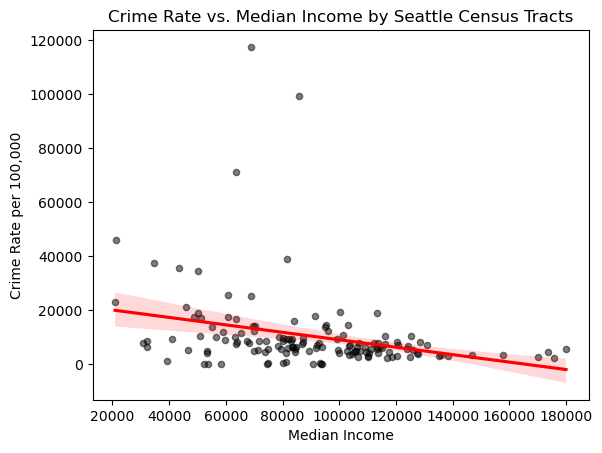

In [26]:
crime_median_plot(grouped_df)

The first plot we generated shows the correlation between total crime rate and median household income by Seattle census tracts. There appears to be a downward trend between the total crime rate and median household income, indicating a potential inverse relationship. Areas with lower median household incomes tend to exhibit higher crime rates, while those with higher median household incomes experience comparatively lower crime rates. This initial observation prompts further investigation into the socioeconomic factors influencing crime rates within specific Seattle census tracts.

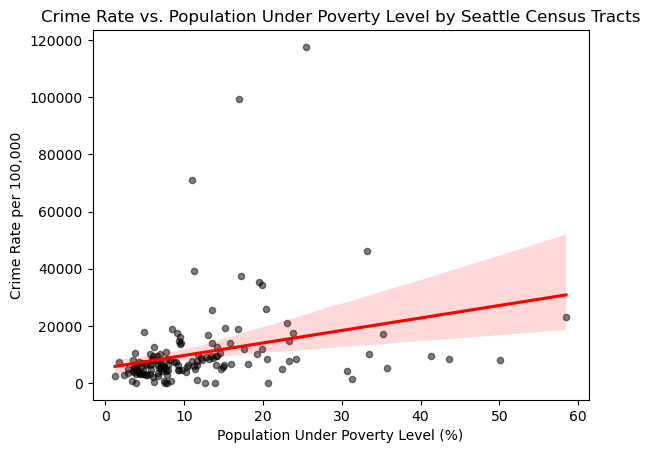

In [27]:
crime_poverty_plot(grouped_df)

The second plot shows the relationship between the total crime rate and the percentage of the population living below the poverty level by Seattle Census Tracts. There appears to be a strong upwards trend with a substantial amount of data points cluttered for areas where the poverty level falls below 10%. This can indicate a potential positive correlation, suggesting that as the poverty level increases, there is a corresponding increase in the crime rate. This aligns with our findings from our previous plot, and both plots are pointing towards the same conclusion, that as socioeconomic status decreases, crime increases.

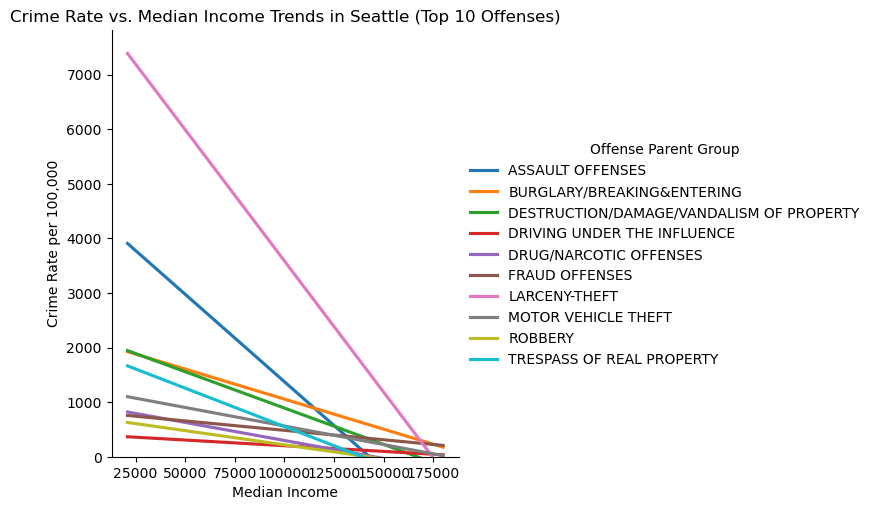

In [28]:
offenses_income_10_plot(offenses_df)

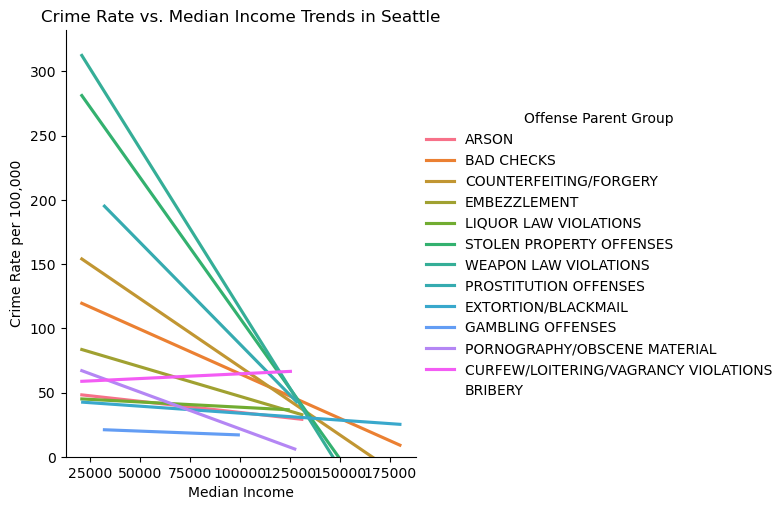

In [29]:
offenses_income_plot(offenses_df)

The 2 plots above show the relationship between the crime rate by offense type and median income. For all top ten common offenses, the graph suggests that as median income increases, the crime rate tends to decrease, regardless of crime type. Larceny-theft shows the steepest decline, followed by assault offenses. These observations may indicate that census tracts with higher income have better resources for crime prevention as well as economic stability to deter individuals from committing theft. We see a similar story in other offenses outside of the top 10 as well, with only 1 exception, "CURFEW/LOITERING/VAGRANCY VIOLATIONS," which happens to be a minor offense. 

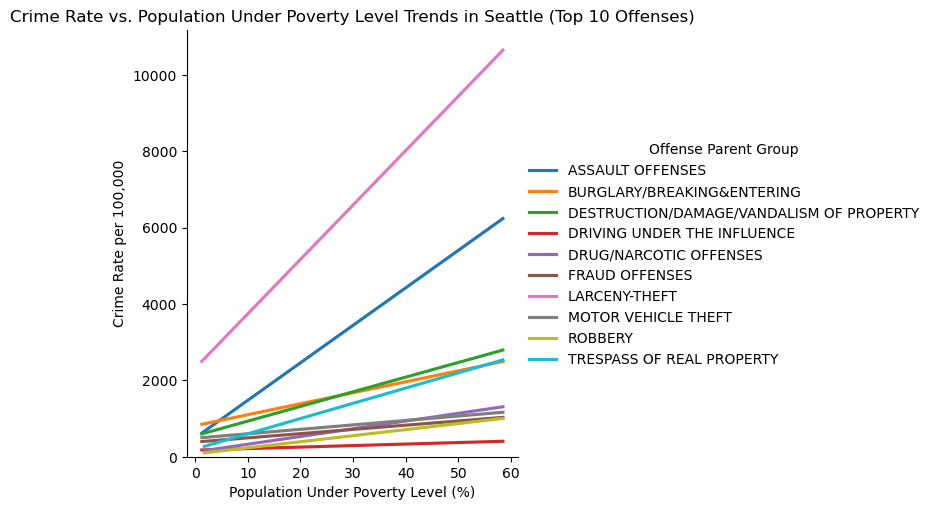

In [30]:
offenses_poverty_10_plot(offenses_df)

In [31]:
offenses_poverty_plot(offenses_df)

The 2 plots above show the relationship between the crime rate by offense type and percentage of the population living in poverty. For all top ten common offenses, the graph suggests that as the percentage of the population living in poverty increases, the crime rate also increases, regardless of crime type. Larceny-theft shows the steepest growth, followed by assault offenses. Again, these observations may indicate that census tracts with higher income have better resources for crime prevention as well as economic stability to deter individuals from committing theft. We see a similar story in other offenses outside of the top 10 as well, with only 2 exception, "CURFEW/LOITERING/VAGRANCY VIOLATIONS" and "PROSTITUTION OFFENSES." Altogether, this suggests a positive correlation between poverty levels and crime rate. Similarly, this aligns with our findings from our other plots. All evidence points towards the same conclusion, that as socioeconomic status decreases, crime increases.

In [32]:
policing_income_plot(policing_df)

The plot above shows the correlation between the average police response time and the median income by census tracts. It can be seen that there is a weak positive correlation between the two variables as the regression line doesn't appear as strong as our previous examples.

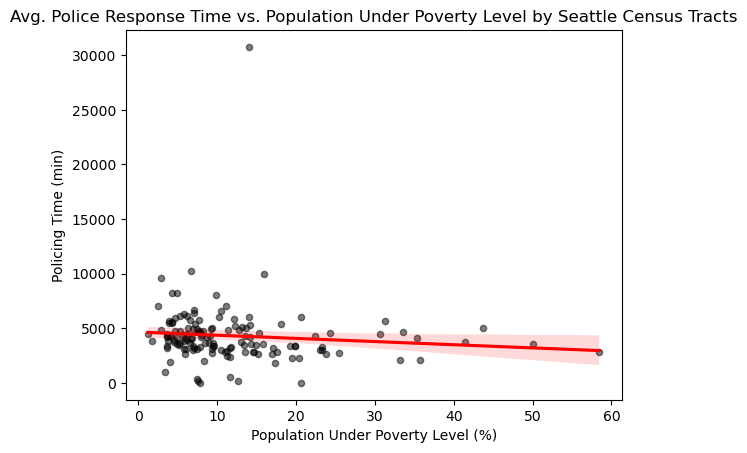

In [33]:
policing_poverty_plot(policing_df)

Similar results are seen in the plot above. We see that there is a weak negative correlation between police response time and the percentage of population in poverty. This suggests that there may be other factors that influence the variance seen in the response times. Interestingly enough, we were expecting average police response times to increase and socioeconomic status decreased, but these plots are leaning more towards the opposite. One hypothesis as to why this could be, connecting what we've learned about the relationship between socioeconomic status and crime rate, is due to higher police activity and personnel in higher crime areas.

In [34]:
display(interactive_map(data))

Just an interactive map to view data by census tract :)

### Impact and Limitations
The results of our analysis have substantial implications for policymakers, law enforcement, and community organizations, and could contribute to real-world, applicable improvements. Understanding the correlations between socioeconomic factors and crime rate allows for targeted interventions and tailored social and economic policies to address specific challenges in high-risk areas. Improved community safety, enhanced resource allocation, and more effective crime prevention strategies are potential benefits.

The setting of our data, which focuses on Seattle, may limit the applicability of our findings to other cities or regions with different socioeconomic dynamics. Each community has unique characteristics that influence the relationship between socioeconomic factors and crime rates, so users should exercise caution when applying our conclusions to contexts other than the Seattle area. Future work could include expanding the scope of our research from the local level (Seattle census tracts) to a larger scale such as nationwide census tracts, city to city, or state to state, so we can re-analyze and generalize trends and patterns.

Another limitation of our analysis is the focus on a specific time frame, which does not capture long-term trends over time. Extending the time frame would offer a more comprehensive, nuanced understanding of the patterns and dynamics. Utilizing longitudinal analysis in the future would allow us to study trends and changes over time to deepen understanding of the connection between socioeconomic factors and crime.

Finally, although our analysis identifies correlations, understanding the root cause would require more in-depth investigation as other unexplored factors may contribute to the observed relationships. Lastly, the accuracy of our findings depends on the quality of the available data, so incomplete or inaccurate data may impact the reliability of our conclusions. Although the datasets we've chosen are of high quality, they still have their issues. For example, our crime dataset does have offenses with missing longitude and latitude variables, meaning we can't source the census tract of the offense. We've had to remove entire offense types due to these missing values. Also, our income dataset is missing median income data for census tract 53.02, University District, which means we cannot utilize crime data in that census tract. Put together, these issues create holes in our data that could affect our conclusions, espicielly due to the relatively narrow nature of our scope for this project.

As far as how users should use our conclusions, they should consider our findings as valuable insights leading towards a truth rather than definitive conclusions. Policymakers and researchers should use our results as starting points for further investigation alongside other data sources.

### Challenge Goals
**1. Multiple datasets**

Along with our crime dataset, we utilized income and poverty datasets at the census tract levels, so we’re looking at 3 datasets in total. Our crime dataset needed to be joined to the income and poverty dataset based census tract, so we’re looking at least 1 merge/join operation. Our 3 research questions each involve at least 2 of the mentioned datasets.

Since we scaled back our project to just Seattle, from Seattle, US cities and US states, due to time constraints and TA recommendation, we've had to also scale back our challenge goal 3x due to us not requiring so many datasets.

**2. New libraries**

We utilized the "requests" library since we needed to use the Census Geocoder API to retrieve census tract data based on the offense longitude and latitude values in our crime dataset. Making requests to this API resulted in us getting relatively messy data that we had to clean/filter, so we could grab the data we wanted, so that could count towards the "Messy Data" challenge goal as well.

Due to us finding better dataset options, we didn't need to resort to web scraping data from certain sites, which dropped our need for "Beautiful Soup" and Selenium's WebDriver framework.

### Plan Evaluation
Our proposed work plan estimates were somewhat accurate, however some tasks did not take as long as initially predicted due to us scaling our project back. Specifically, we had to adjust our plan accordingly as the initial workload had a fourth, rather tough and time-consuming research question, which we eventually decided to discard as we wanted to focus and dedicate our time to just three research questions. Other than that, our estimates were also different from reality because of our efficient workflow. Work was delegated to each team member at the start of the week according to a detailed weekly plan.

### Testing
We tested our code by testing our functions on a specifically chosen small subset of our 3 datasets, about 10 rows each, so that we could manually verify the results. For our tests, we simply used python assertions after running each function, testing critical components of the returned result that the function should have manipulated. If the results were as expected, we could then infer that our functions would work as expected on our much larger, complete datasets. We could espicielly infer this because our chose testing datasets were specifically designed to be "troublesome," including missing values, rows that would not make it past the cleaning process, rows that would be lost during the merges, etc.

In [35]:
crime_test = pd.read_csv('./data/SPD_Crime_Data__2008-Present_20240226.csv')
crime_test = crime_test[crime_test['Offense ID'].isin([
    12605873663, 7686420892, 12604929082, 7633823762, 7630358285, 7696639702, 7664183259, 7685572628, 7631819895, 
    7687620453])]

income_test = pd.read_csv('./data/ACSST5Y2018.S1903-Data.csv')
income_test = income_test[income_test['GEO_ID'].isin([
    '1400000US53033010100', '1400000US53033006200', '1400000US53033001701', '1400000US53033007900', 
    '1400000US53033003600','1400000US53033005302', '1400000US53033001500', '1400000US53033002800', 
    '1400000US53033007401', '1400000US53033000100'])]

poverty_test = pd.read_csv('./data/Poverty_and_Near_Poverty_Map_Full_Data_data.csv')
poverty_test = poverty_test[poverty_test['Census Tract'].isin([
    '1', '15', '17.01', '28', '36', '62', '74.01', '79', '101', '53.02'])]

boundries_test = gpd.read_file('./data/cb_2018_53_tract_500k/cb_2018_53_tract_500k.shp')
boundries_test = boundries_test[boundries_test['NAME'].isin([
    '1', '15', '17.01', '28', '36', '62', '74.01', '79', '101', '53.02'])]

In [36]:
crime_test = crime_clean(crime_test)

assert len(crime_test) == 7
assert list(crime_test.columns) == ['Census Tract', 'Offense Start DateTime', 'Report DateTime', 
                                    'Offense Parent Group', 'Longitude', 'Latitude']
assert len(crime_test[(crime_test['Longitude'] == 0) | (crime_test['Latitude'] == 0)]) == 0
assert len(crime_test['Report DateTime'].dt.year == 2018) == 7

In [37]:
crime_test = crime_tracts(crime_test)

assert len(crime_test) == 7
assert list(crime_test.columns) == ['Census Tract', 'Offense Start DateTime', 'Report DateTime', 
                                    'Offense Parent Group']
assert list(crime_test['Census Tract']) == ['101', '75', '62', '17.01', '79', '79', '53.02']

In [38]:
income_test = income_clean(income_test)

assert len(income_test) == 9
assert list(income_test.columns) == ['Census Tract', 'Median Income']
assert list(income_test['Census Tract']) == ['1', '15', '17.01', '28', '36', '62', '74.01', '79', '101']
assert str(income_test.dtypes['Median Income']) == 'int64'

In [39]:
poverty_test = poverty_clean(poverty_test)

assert len(poverty_test) == 10
assert list(poverty_test.columns) == ['Census Tract', 'Population Under 100% Poverty Level', 'Total Population']
assert list(poverty_test['Population Under 100% Poverty Level']) == [14.24, 5.31, 5.24, 19.23, 14.53, 68.79, 7.42, 
                                                                     13.54, 4.5, 14.05]

In [40]:
boundries_test = geo_clean(boundries_test)

assert len(boundries_test) == 10
assert list(boundries_test.columns) == ['Census Tract', 'geometry']

In [41]:
merged_test = cip_merge(crime_test, income_test, poverty_test)

assert len(merged_test) == 5
assert list(merged_test.columns) == ['Census Tract', 'Offense Start DateTime', 'Report DateTime', 
                                     'Offense Parent Group', 'Median Income', 'Population Under 100% Poverty Level', 
                                     'Total Population']

In [42]:
grouped_test = crime_by_census(merged_test)

assert len(grouped_test) == 4
assert list(grouped_test.reset_index().columns) == ['Census Tract', 'Median Income', 'Total Population', 
                                      'Population Under 100% Poverty Level', 'Total Offenses', 
                                      'Crime Rate per 100,000']
grouped_test['Crime Rate per 100,000']
assert list(grouped_test['Crime Rate per 100,000']) == [11.0, 25.0, 22.0, 32.0]

In [43]:
offenses_test = offenses_by_census(merged_test)

assert len(offenses_test) == 5
assert list(offenses_test.columns) == ['Census Tract', 'Median Income', 'Total Population', 
                                       'Population Under 100% Poverty Level', 'Offense Parent Group', 'Offense Count', 
                                       'Crime Rate per 100,000']
assert list(offenses_test['Crime Rate per 100,000']) == [11.0, 25.0, 22.0, 16.0, 16.0]

In [44]:
policing_test = policing_by_census(merged_test)

assert len(policing_test) == 4
assert list(policing_test.columns) == ['Census Tract', 'Median Income', 'Population Under 100% Poverty Level', 
                                       'Start-Report Time Diff']
assert list(policing_test['Start-Report Time Diff']) == [254.0, 0.0, 429.0, 493.0]

In [45]:
offenses_wide_test = offenses_wide(offenses_test)

assert len(offenses_wide_test) == 4
assert list(
    offenses_wide_test.reset_index().columns) == ['Census Tract', 
                                                  'Offense Count-DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 
                                                  'Offense Count-LARCENY-THEFT', 
                                                  'Crime Rate per 100,000-DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 
                                                  'Crime Rate per 100,000-LARCENY-THEFT']

In [46]:
data_test = gop_merge(grouped_test, offenses_wide_test, policing_test, boundries_test)

assert len(data_test) == 4
assert list(data_test.columns) == ['Census Tract', 'geometry', 'Median Income', 'Total Population', 
                                   'Percent Under Poverty Level', 'Total Offenses', 'Crime Rate per 100,000', 
                                   'Crime Rate per 100,000-DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY', 
                                   'Crime Rate per 100,000-LARCENY-THEFT', 'Avg. Police Response Time (min)']

### Collaboration
Besides the obvious resources such as library documentation:

Referenced Stackoverflow to fix Pandas warnings or random bugs as well as figure out how to achieve certain things in Jupyter notebooks, caching variables or skipping code cells for example.

Referenced the following websites to create linear regression models for our analysis:
https://www.tutorialspoint.com/seaborn/seaborn_regplot_method.htm
https://seaborn.pydata.org/generated/seaborn.regplot.html

Referenced the following PDF to figure out how to utilize the Census Geocoder API:
https://geocoding.geo.census.gov/geocoder/Geocoding_Services_API.pdf